## Train the model with tf-idf

In [28]:
import pandas as pd

# Load dataset
df = pd.read_excel("processed_reviews.xlsx")

# Check for missing values
missing_values = df.isnull().sum()
print("🔍 Missing Values in Each Column:\n", missing_values)

# Check if processed_reviews column contains empty strings
empty_reviews = (df["processed_reviews"] == "").sum()
print(f"\n🔍 Empty Processed Reviews: {empty_reviews}")


🔍 Missing Values in Each Column:
 brand                0
model                0
price                0
Ratings              0
processed_reviews    2
dtype: int64

🔍 Empty Processed Reviews: 0


### replacing nan with no reviews

In [29]:
df["processed_reviews"] = df["processed_reviews"].fillna("no reviews")

## converting text to features

In [30]:
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Define Features (X) and Labels (y)
X = df["processed_reviews"].astype(str)  # Ensure all text is in string format
y = df["Ratings"].apply(lambda x: 1 if x > 3 else 0)  # Convert ratings to binary (Positive=1, Negative=0)

# Convert text into numerical values using TF-IDF
tfidf = TfidfVectorizer(max_features=5000, stop_words="english")
X_tfidf = tfidf.fit_transform(X)

with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)

# Split into training & testing sets (80% train, 20% test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, stratify=y, random_state=42)


print("✅ TF-IDF Feature Engineering Complete! Ready for training models.")


✅ TF-IDF Feature Engineering Complete! Ready for training models.


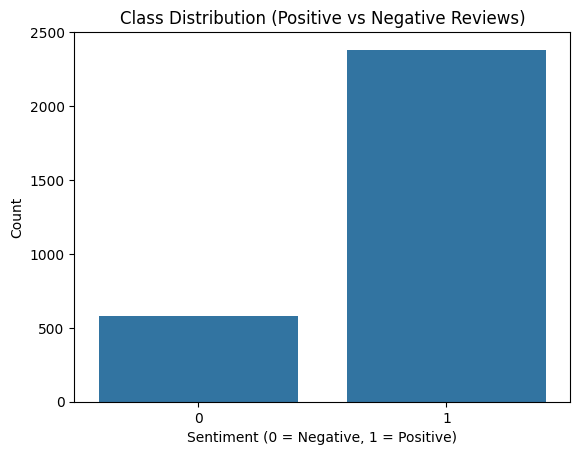

Negative Reviews: 580
Positive Reviews: 2381


In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count class distribution
sns.countplot(x=y)
plt.title("Class Distribution (Positive vs Negative Reviews)")
plt.xlabel("Sentiment (0 = Negative, 1 = Positive)")
plt.ylabel("Count")
plt.show()

# Print class counts
print("Negative Reviews:", sum(y == 0))
print("Positive Reviews:", sum(y == 1))



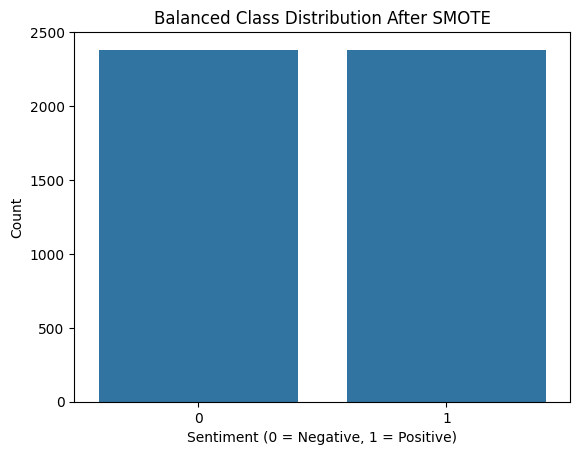

New Negative Reviews: 2381
New Positive Reviews: 2381


In [39]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)

# Check new distribution
sns.countplot(x=y_resampled)
plt.title("Balanced Class Distribution After SMOTE")
plt.xlabel("Sentiment (0 = Negative, 1 = Positive)")
plt.ylabel("Count")
plt.show()

# Print class counts after SMOTE
print("New Negative Reviews:", sum(y_resampled == 0))
print("New Positive Reviews:", sum(y_resampled == 1))


In [40]:
from sklearn.model_selection import train_test_split

# Split resampled data into training & test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

# Print class distribution in training & test sets
print("Training Labels Distribution:\n", y_train.value_counts())
print("Test Labels Distribution:\n", y_test.value_counts())


Training Labels Distribution:
 Ratings
1    1905
0    1904
Name: count, dtype: int64
Test Labels Distribution:
 Ratings
0    477
1    476
Name: count, dtype: int64


In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Train Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Predict on test data
y_pred_log = log_reg.predict(X_test)

# Evaluate Model
print(f"✅ Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_log):.4f}")
print("\n🔍 Classification Report:\n", classification_report(y_test, y_pred_log))


✅ Logistic Regression Accuracy: 0.8804

🔍 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.95      0.89       477
           1       0.94      0.82      0.87       476

    accuracy                           0.88       953
   macro avg       0.89      0.88      0.88       953
weighted avg       0.89      0.88      0.88       953



In [42]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest Model
rf_model = RandomForestClassifier(n_estimators=300, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test data
y_pred_rf = rf_model.predict(X_test)

# Evaluate Model
print(f"✅ Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("\n🔍 Classification Report:\n", classification_report(y_test, y_pred_rf))


✅ Random Forest Accuracy: 0.9192

🔍 Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92       477
           1       0.96      0.87      0.92       476

    accuracy                           0.92       953
   macro avg       0.92      0.92      0.92       953
weighted avg       0.92      0.92      0.92       953



In [43]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize & Pad Sequences
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)

# Pad sequences to 100 tokens
X_padded = pad_sequences(X_seq, maxlen=100, padding="post", truncating="post")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Define LSTM Model
lstm_model = Sequential([
    Embedding(5000, 128, input_length=100),
    Bidirectional(LSTM(64, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.2),
    LSTM(32),
    Dense(1, activation="sigmoid")
])

# Compile model
lstm_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train model
lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate model
loss, accuracy = lstm_model.evaluate(X_test, y_test)
print(f"✅ LSTM Model Accuracy: {accuracy:.4f}")


Epoch 1/10


C:\Users\dagbo_b40tnyc\OneDrive\all_leagues _prediction\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


74/74 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.7533 - loss: 0.5314 - val_accuracy: 0.8094 - val_loss: 0.6172
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.8032 - loss: 0.4974 - val_accuracy: 0.8094 - val_loss: 0.5926
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.8185 - loss: 0.4770 - val_accuracy: 0.8094 - val_loss: 0.5514
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.7938 - loss: 0.5081 - val_accuracy: 0.8094 - val_loss: 0.6726
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.8001 - loss: 0.5008 - val_accuracy: 0.8078 - val_loss: 0.5121
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.8237 - loss: 0.4656 - val_accuracy: 0.8094 - val_loss: 0.4902
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.8189 - loss: 0.4624 - val_accuracy: 0.8162 - val_loss: 0.4286
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.8260 - loss: 0.3889 - val_accuracy: 0.8735 - val_loss: 0.

In [44]:
import numpy as np
with open("tfidf_vectorizer.pkl", "rb") as f:
    tfidf = pickle.load(f)

# Transform input using the same TF-IDF
review_tfidf = tfidf.transform(df["processed_reviews"].astype(str))

# Sample test reviews
test_reviews = [
    "This is the best product ever, totally worth the money!",
    "Terrible experience, I would never buy this again!",
    "It's okay, I guess. Not bad, but not amazing either."
]

# Convert text to numerical format
test_reviews_tfidf = tfidf.transform(test_reviews)

# Make predictions
log_pred = log_reg.predict(test_reviews_tfidf)
rf_pred = rf_model.predict(test_reviews_tfidf)

# Tokenize and pad for LSTM
test_reviews_seq = tokenizer.texts_to_sequences(test_reviews)
test_reviews_padded = pad_sequences(test_reviews_seq, maxlen=100, padding="post", truncating="post")
lstm_pred = lstm_model.predict(test_reviews_padded)
lstm_pred = [1 if p > 0.5 else 0 for p in lstm_pred]  # Convert probabilities to binary labels

# Print results
for i, review in enumerate(test_reviews):
    print(f"\n🔹 **Review:** {review}")
    print(f"   - Logistic Regression Prediction: {'Positive' if log_pred[i] == 1 else 'Negative'}")
    print(f"   - Random Forest Prediction: {'Positive' if rf_pred[i] == 1 else 'Negative'}")
    print(f"   - LSTM Prediction: {'Positive' if lstm_pred[i] == 1 else 'Negative'}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step

🔹 **Review:** This is the best product ever, totally worth the money!
   - Logistic Regression Prediction: Positive
   - Random Forest Prediction: Positive
   - LSTM Prediction: Positive

🔹 **Review:** Terrible experience, I would never buy this again!
   - Logistic Regression Prediction: Positive
   - Random Forest Prediction: Positive
   - LSTM Prediction: Negative

🔹 **Review:** It's okay, I guess. Not bad, but not amazing either.
   - Logistic Regression Prediction: Negative
   - Random Forest Prediction: Positive
   - LSTM Prediction: Negative


In [46]:
import tensorflow as tf

# Save the model in Keras format
lstm_model.save("lstm_sentiment_model.keras")
print("✅ LSTM model saved successfully in .keras format!")

# Alternative: Save as HDF5 (.h5 format)
lstm_model.save("lstm_sentiment_model.h5")
print("✅ LSTM model saved successfully in .h5 format!")


✅ LSTM model saved successfully in .keras format!
✅ LSTM model saved successfully in .h5 format!


In [47]:
import pickle

# Save the tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

print("✅ Tokenizer saved successfully!")


✅ Tokenizer saved successfully!
